## Building IntraDay Stock Price Databse with SQLite

In [1]:
import pandas as pd
import sqlite3
import requests

### Downloading data from Alpha Vantage

In [2]:
alpha_vantage_api_key = 'BGFBHXX2VFS45G1C'

In [21]:
url = f"https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol=IBM&interval=1min&apikey={alpha_vantage_api_key}&outputsize=full"

In [22]:
r = requests.get(url)

In [23]:
r

<Response [200]>

In [24]:
data = r.json()

In [25]:
pd.DataFrame(data.get('Time Series (1min)')).T

,1. open,2. high,3. low,4. close,5. volume
2024-10-11 19:59:00,232.8000,232.8000,232.8000,232.8000,1
2024-10-11 19:51:00,232.9000,233.1700,232.9000,233.1700,11
2024-10-11 19:31:00,232.6000,232.6000,232.6000,232.6000,5
2024-10-11 19:24:00,232.8400,233.0000,232.8000,232.8000,10
2024-10-11 19:20:00,233.2000,233.2000,233.2000,233.2000,3
...,...,...,...,...,...
2024-09-12 04:07:00,209.8000,209.8000,209.6100,209.6100,9
2024-09-12 04:04:00,210.0000,210.0000,209.6100,209.6100,2
2024-09-12 04:02:00,210.1700,210.1700,209.5700,210.0100,14
2024-09-12 04:01:00,210.0000,210.0000,210.0000,210.0000,1


In [30]:
def fetch_intraday_data(ticker, interval='1min'):
    url = f"https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={ticker}&interval={interval}&apikey={alpha_vantage_api_key}&outputsize=full"
    response = requests.get(url)
    data = response.json()
    # print(data)

    time_series = data.get(f"Time Series ({interval})", {})
    if not time_series:
        print(f"No data returned for {ticker}")
        return None

    df = pd.DataFrame(time_series).T
    df.index.name = 'timestamp'
    df.columns = ['open', 'high', 'low', 'close', 'volume']
    df = df.sort_index()
    df.reset_index(inplace=True)
    df['ticker'] = ticker
    return df

In [32]:
df = fetch_intraday_data('IBM')

,timestamp,open,high,low,close,volume,ticker
0,2024-09-12 04:00:00,209.9900,210.0000,209.9900,210.0000,130,IBM
1,2024-09-12 04:01:00,210.0000,210.0000,210.0000,210.0000,1,IBM
2,2024-09-12 04:02:00,210.1700,210.1700,209.5700,210.0100,14,IBM
3,2024-09-12 04:04:00,210.0000,210.0000,209.6100,209.6100,2,IBM
4,2024-09-12 04:07:00,209.8000,209.8000,209.6100,209.6100,9,IBM
...,...,...,...,...,...,...,...
12707,2024-10-11 19:20:00,233.2000,233.2000,233.2000,233.2000,3,IBM
12708,2024-10-11 19:24:00,232.8400,233.0000,232.8000,232.8000,10,IBM
12709,2024-10-11 19:31:00,232.6000,232.6000,232.6000,232.6000,5,IBM
12710,2024-10-11 19:51:00,232.9000,233.1700,232.9000,233.1700,11,IBM


<Axes: xlabel='timestamp'>

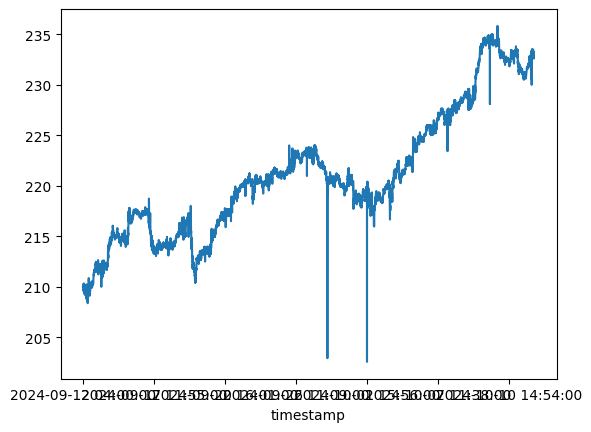

In [35]:
df.set_index('timestamp').close.astype(float).plot()

### Connecting with SQLite Database

In [37]:
conn = sqlite3.connect('intraday_stock_prices.db')
cursor = conn.cursor()

cursor.execute('''
    CREATE TABLE IF NOT EXISTS intraday_prices (
    ticker TEXT,
    timestamp TEXT,
    open REAL,
    high REAL,
    low REAL,
    close REAL,
    volume INTEGER
    )
''')

conn.commit()

In [38]:
def get_latest_timestamp(ticker):
    query="""
        SELECT MAX(timestamp) FROM intraday_prices WHERE ticker = ?
    """
    cursor.execute(query, (ticker,))
    result = cursor.fetchone()[0]
    return result

In [40]:
get_latest_timestamp('IBM')

In [41]:
def store_data_to_db(data, latest_timestamp):
    if data is not None:
        if latest_timestamp:
            data = data[data['timestamp'] > latest_timestamp]
        if not data.empty:
            data.to_sql('intraday_prices', conn, if_exists='append', index=False)
            print(f"Data for {data['ticker'].iloc[0]} stored successfully.")
        else:
            print("No new data to store.")
    else:
        print("No data to store.")

In [43]:
def main():
    tickers = ["MSFT", "IBM"]
    for ticker in tickers:
        latest_timestamp = get_latest_timestamp(ticker)
        data = fetch_intraday_data(ticker)
        store_data_to_db(data, latest_timestamp)

if __name__ == "__main__":
    main()

No new data to store.
No new data to store.


### Querying the database

In [53]:
def query_data(ticker, start_time, end_time):
    query = f"""
        SELECT * FROM intraday_prices 
        WHERE ticker = '{ticker}' AND 
        timestamp BETWEEN '{start_time}' AND '{end_time}'
        ORDER BY timestamp desc
    """
    df = pd.read_sql(query, conn)
    return df

In [54]:
df = query_data('IBM', '2024-10-10 00:00:00', '2024-10-10 19:59:00')
df

,ticker,timestamp,open,high,low,close,volume
0,IBM,2024-10-10 19:59:00,233.180,233.180,233.070,233.070,33
1,IBM,2024-10-10 19:57:00,233.070,233.070,233.070,233.070,5
2,IBM,2024-10-10 19:54:00,233.070,233.070,233.070,233.070,1
3,IBM,2024-10-10 19:52:00,233.070,233.070,233.070,233.070,20
4,IBM,2024-10-10 19:50:00,233.193,233.193,233.193,233.193,2
...,...,...,...,...,...,...,...
579,IBM,2024-10-10 04:04:00,234.000,234.170,234.000,234.000,23
580,IBM,2024-10-10 04:03:00,234.000,234.190,233.890,234.190,25
581,IBM,2024-10-10 04:02:00,234.010,234.010,234.010,234.010,3
582,IBM,2024-10-10 04:01:00,234.180,234.190,234.010,234.190,15


<Axes: xlabel='timestamp'>

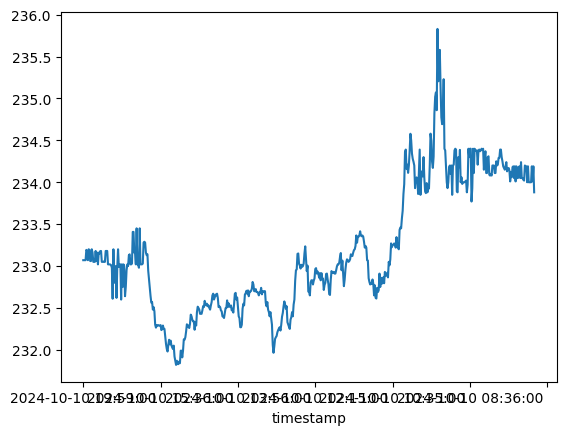

In [56]:
df.set_index('timestamp').close.plot()

In [57]:
conn.close()